In [1]:
import cv2, os, random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
from glob import glob
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [3]:
seed = 2020
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
path = 'dataset/dogs-vs-cats/work/'

In [5]:
ROW, COL = 96, 96

dogs, cats = [], []
test_dogs, test_cats= [], []
test_dogl, test_catl = [], []
y_dogs, y_cats = [], []

In [6]:
dog_path = os.path.join(path, 'train/dog.*')
for dog_img in glob(dog_path):
    dog = cv2.imread(dog_img)
    dog = cv2.cvtColor(dog, cv2.COLOR_BGR2GRAY)
    dog = cv2.resize(dog, (ROW, COL))
    dog = image.img_to_array(dog)
    dogs.append(dog)
print('All dog images loaded')

All dog images loaded


In [7]:
dog_path = os.path.join(path, 'test/dog.*')
for dog_img in glob(dog_path):
    dog = cv2.imread(dog_img)
    dog = cv2.cvtColor(dog, cv2.COLOR_BGR2GRAY)
    dog = cv2.resize(dog, (ROW, COL))
    dog = image.img_to_array(dog)
    test_dogs.append(dog)
print('All test dog images loaded')

All test dog images loaded


In [8]:
cat_path = os.path.join(path, 'train/cat.*')
for cat_img in glob(cat_path):
    cat = cv2.imread(cat_img)
    cat = cv2.cvtColor(cat, cv2.COLOR_BGR2GRAY)
    cat = cv2.resize(cat, (ROW, COL))
    cat = image.img_to_array(cat)
    cats.append(cat)
print('All cat images loaded')

All cat images loaded


In [9]:
cat_path = os.path.join(path, 'test/cat.*')
for cat_img in glob(cat_path):
    cat = cv2.imread(cat_img)
    cat = cv2.cvtColor(cat, cv2.COLOR_BGR2GRAY)
    cat = cv2.resize(cat, (ROW, COL))
    cat = image.img_to_array(cat)
    test_cats.append(cat)
print('All test cat images loaded')

All test cat images loaded


In [10]:
def shows(label):
    plt.figure(figsize=(12, 8))
    for i in range(5):
        plt.subplot(1, 5, i+1)
        img = image.array_to_img(random.choice(label))
        plt.imshow(img, cmap=plt.get_cmap('gray'))
        plt.axis('off')

    plt.show()

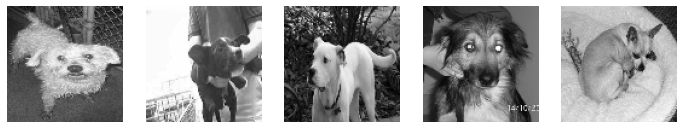

In [11]:
shows(dogs)

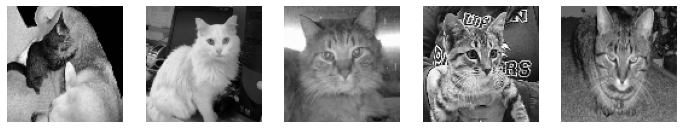

In [12]:
shows(cats)

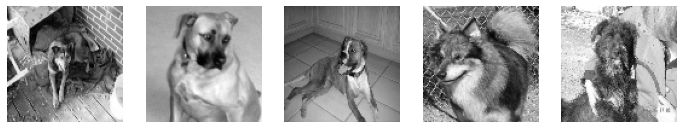

In [13]:
shows(test_dogs)

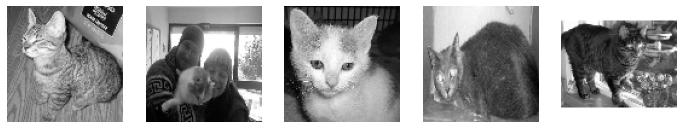

In [14]:
shows(test_cats)

In [15]:
y_dogs = [1 for item in enumerate(dogs)]
y_cats = [0 for item in enumerate(cats)]
test_dogl = [1 for item in enumerate(test_dogs)]
test_catl = [0 for item in enumerate(test_cats)]

In [16]:
dogs = np.asarray(dogs).astype('float32') / 255
cats = np.asarray(cats).astype('float32') / 255
y_dogs = np.asarray(y_dogs).astype('int32')
y_cats = np.asarray(y_cats).astype('int32')

In [17]:
dogs.shape, y_dogs.shape

((10000, 96, 96, 1), (10000,))

In [18]:
x_train = np.concatenate((dogs, cats), axis = 0)
y_train = np.concatenate((y_dogs, y_cats), axis = 0)

In [19]:
x_train.shape, y_train.shape

((20000, 96, 96, 1), (20000,))

In [20]:
y_train = tf.keras.utils.to_categorical(y_train, 2)

In [21]:
test_dogs = np.asarray(test_dogs).astype('float32') / 255
test_cats = np.asarray(test_cats).astype('float32') / 255
test_dogl = np.asarray(test_dogl).astype('int32')
test_catl = np.asarray(test_catl).astype('int32')

In [22]:
x_test = np.concatenate((test_dogs, test_cats), axis = 0)
y_test = np.concatenate((test_dogl, test_catl), axis = 0)

In [23]:
y_test = tf.keras.utils.to_categorical(y_test, 2)

In [24]:
model = Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(ROW, COL, 1),  activation='relu'),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.1),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.1),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(.5),
    Dense(256, activation='relu'),
    Dropout(.5),
    Dense(128, activation='relu'),
    Dropout(.5),
    Dense(64, activation='relu'),
    Dropout(.5),
    Dense(2, activation='softmax')
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0

In [26]:
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Nadam(),
             metrics = ['accuracy'])

In [27]:
modelpath = "../model/dogsvscats-{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = keras.callbacks.ModelCheckpoint(modelpath,verbose=1, save_best_only=True)

In [28]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32, callbacks=[checkpointer])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
19968/20000 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.4935
Epoch 00001: val_loss improved from inf to 0.69325, saving model to ../model/dogsvscats-01-0.6932.hdf5
20000/20000 [==============================] - 434s 22ms/sample - loss: 0.6940 - accuracy: 0.4934 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
19968/20000 [============================>.] - ETA: 1s - loss: 0.6960 - accuracy: 0.5002
Epoch 00002: val_loss improved from 0.69325 to 0.69315, saving model to ../model/dogsvscats-02-0.6932.hdf5
20000/20000 [==============================] - 716s 36ms/sample - loss: 0.6960 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
19968/20000 [============================>.] - ETA: 1s - loss: 0.6935 - accuracy: 0.4983
Epoch 00003: val_loss did not improve from 0.69315
20000/20000 [==============================] - 716s 36ms/sample - loss: 0.6935 - accuracy: 0.4983 - val_loss: 

In [29]:
del model

In [32]:
model = keras.models.load_model('../model/dogsvscats-05-0.6931.hdf5')

In [33]:
model.evaluate(x_test , y_test, verbose=0)

[0.6931491791725158, 0.5]